# Solving the Navier-Stokes equation with tensor-product space-time FEM in FEniCS and equal order dG(r)-discretization for velocity and pressure

In [1]:
# FEniCS for spatial FEM
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

## Create temporal basis in SymPy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import Mul, Id, symbols, init_printing, expand, compose, diff, lambdify, Piecewise
from IPython.display import Math, display
from fenics import Mesh, VectorElement, Function, TrialFunction, TestFunction, TestFunctions, FunctionSpace, dx, inner, grad, FiniteElement, MixedElement, Constant, assemble, Expression, interpolate, solve, DirichletBC, plot, errornorm, set_log_active, derivative, parameters, split, dot, div, CompiledSubDomain, MeshFunction, sqrt, Measure, FacetNormal, Identity
from ufl import replace
import time
import pandas as pd

set_log_active(False) # turn off FEniCS logging
parameters["reorder_dofs_serial"] = False

t = symbols("t")
init_printing()

TIME_DG_QUADRATURE = "Gauss-Lobatto"
PROBLEM = "2D-3" #"2D-2"

# HELPER FUNCTIONS
# compute temporal basis functions from the roots
def compute_basis_functions(roots):
    basis = []
    for i in range(len(roots)):
        f = 1 + 0*Id(t)
        for j in range(len(roots)):
            if i != j:
                f = Mul(f,(t - roots[j]) / (roots[i] - roots[j]))
        #basis.append(f)
        basis.append(expand(f))
    return basis

# transform roots from [-1, 1] to [0, 1]
def transform_roots(roots):
    new_roots = []
    for root in roots:
        new_roots.append((root + 1) / 2)
    return new_roots

# dictionary of temporal bases depending on the polynomial degree
# FE basis on reference element (0,1)
φ = {}
roots = {}

roots[0] = [1.]
φ[0] = [1 + 0*Id(t)]
roots[1] = [0., 1.]
φ[1] = [1-t, t]
roots[2] = transform_roots([-1, 0, 1])
φ[2] = compute_basis_functions(roots[2])

class TimeFE:
    def __init__(self, r=1, a=0., b=1., n_time=1, n_q_points=3):
        self.r = r # polynomial degree in time
        self.n_time = n_time # number of temporal elements
        self.n_dofs = (self.r+1) * self.n_time # total number of temporal dofs on slab
        self.dof_locations = []
        self.a = a # start time of slab
        self.b = b # end time of slab
        self.k = (self.b - self.a) / self.n_time
        self.epsilon = self.k * 1e-10

        self.generate_mesh()
        self.get_full_basis()
        self.lambdify_basis()
        self.compute_quadrature(n_q_points)

    def generate_mesh(self):
        # create an uniform temporal mesh with mesh size self.k
        self.mesh = [(self.a, self.a+self.k)]
        while len(self.mesh) < self.n_time:
            self.mesh.append((self.mesh[-1][1], self.mesh[-1][1]+self.k))

    # transform basis functions from [0,1] to [a,b]
    def transform_function(self, f, a, b):
        return compose(f, (t-a)/(b-a)) # = f((t-a)/(b-a))
    
    def transform_derivative(self, a, b):
        return 1 / (b-a)

    # get full FE basis and its derivative on temporal mesh
    def get_full_basis(self):
        self._basis = []
        self._basis_derivative = []
        self.local_dofs = {}
        i = 0
        for (a,b) in self.mesh:
            self.local_dofs[(a,b)] = []
            for f, t_q in zip(φ[self.r], roots[self.r]):
                self._basis.append(self.transform_function(f, a, b))
                self._basis_derivative.append(diff(self._basis[-1],t))
                #print(diff(self._basis[-1],t))
                #print(self.transform_function(diff(f,t), a, b) * self.transform_derivative(a, b))
                self.local_dofs[(a,b)].append(i)
                self.dof_locations.append(t_q*(b-a)+a)
                i += 1

    # convert SymPy functions to Python functions and ensure that they are 0 outside the element that they are defined on
    def lambdify_basis(self):
        self.phi = []
        self.dt_phi = []

        for (a,b) in self.mesh:
            for i in self.local_dofs[(a,b)]:
                self.phi.append(
                    lambdify(
                        t,
                        Piecewise(
                            (0, t < a),
                            (0, t > b),
                            (self._basis[i], True)
                        )
                    )
                )

                self.dt_phi.append(
                    lambdify(
                        t,
                        Piecewise(
                            (0, t < a),
                            (0, t > b),
                            (self._basis_derivative[i], True)
                        )
                    )
                )

    def compute_quadrature(self, n_q_points):
        # Gauss-Legendre quadrature points and weights on [-1,1]
        quad_points, quad_weights = np.polynomial.legendre.leggauss(n_q_points)

        # transform quadrature points and weights from [-1,1] to [a,b] for each temporal element [a,b]
        self.quadrature = {}
        for (a, b) in self.mesh:
            t_q = 0.5 * (b-a) * quad_points + 0.5 * (a+b)
            w_q = 0.5 * (b-a) * quad_weights
            self.quadrature[(a,b)] = [(t_q[i], w_q[i]) for i in range(t_q.shape[0])]
            
        # Gauss-Legendre quadrature points and weights on [-1,1]
        quad_points, quad_weights = np.polynomial.legendre.leggauss(n_q_points+2)

        # transform quadrature points and weights from [-1,1] to [a,b] for each temporal element [a,b]
        self.quadrature_fine = {}
        for (a, b) in self.mesh:
            t_q = 0.5 * (b-a) * quad_points + 0.5 * (a+b)
            w_q = 0.5 * (b-a) * quad_weights
            self.quadrature_fine[(a,b)] = [(t_q[i], w_q[i]) for i in range(t_q.shape[0])]

    def plot_basis(self, basis_type="function", title=None):
        assert basis_type in ["function", "derivative"], f"basis_type='{basis_type}' has not been implemented."

        _t = np.linspace(self.a, self.b, 100)
        for i in range(len(self.phi)):
            if basis_type == "function":
                plt.plot(_t, [self.phi[i](time_point) for time_point in _t], label=rf"$\varphi_{{{i}}}$")
            elif basis_type == "derivative":
                plt.plot(_t, [self.dt_phi[i](time_point) for time_point in _t], label=rf"$\partial_t \varphi_{{{i}}}$")

        plt.xlabel("t")
        plt.ylabel("f(t)")
        plt.legend()
        if title is not None:
            plt.title(title)
        plt.show()
        
    def get_solution_at_time(self, time_point, U):
        tmp = np.zeros_like(U[0])
        for i in range(self.n_dofs):
            tmp += Time.phi[i](time_point) * U[i]
        return tmp

## Assemble space-time integrals using numerical quadrature in time and FEniCS forms in space

CONFIG: problem = 2D-3, s = (2/1), r = 1 (Gauss-Lobatto), slab_size = 0.03125, n_x = 1


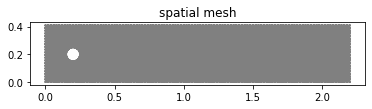

Number of spatial DoFs: 27720 (24574 + 3146)
Solving on slab_0 = Ω x (0.0, 0.03125) ...
Spaces = [v,v,p,p,]
t = 0.03125:


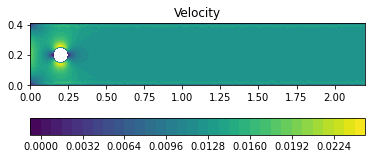

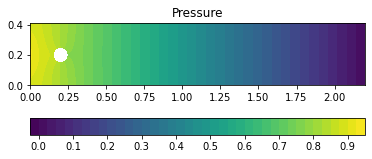

Done.

Solving on slab_1 = Ω x (0.03125, 0.0625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_2 = Ω x (0.0625, 0.09375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_3 = Ω x (0.09375, 0.125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_4 = Ω x (0.125, 0.15625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_5 = Ω x (0.15625, 0.1875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_6 = Ω x (0.1875, 0.21875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_7 = Ω x (0.21875, 0.25) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_8 = Ω x (0.25, 0.28125) ...
Spaces = [v,v,p,p,]
t = 0.28125:


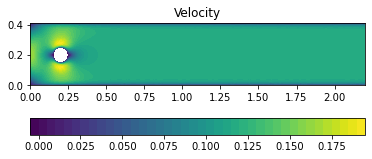

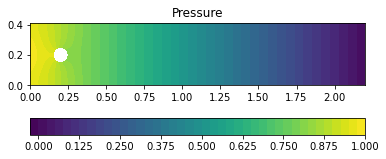

Done.

Solving on slab_9 = Ω x (0.28125, 0.3125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_10 = Ω x (0.3125, 0.34375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_11 = Ω x (0.34375, 0.375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_12 = Ω x (0.375, 0.40625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_13 = Ω x (0.40625, 0.4375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_14 = Ω x (0.4375, 0.46875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_15 = Ω x (0.46875, 0.5) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_16 = Ω x (0.5, 0.53125) ...
Spaces = [v,v,p,p,]
t = 0.53125:


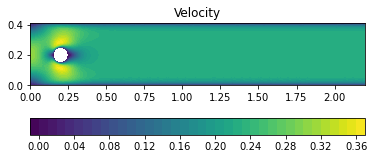

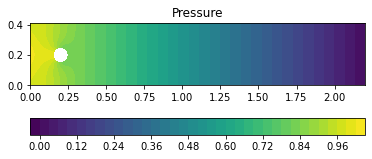

Done.

Solving on slab_17 = Ω x (0.53125, 0.5625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_18 = Ω x (0.5625, 0.59375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_19 = Ω x (0.59375, 0.625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_20 = Ω x (0.625, 0.65625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_21 = Ω x (0.65625, 0.6875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_22 = Ω x (0.6875, 0.71875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_23 = Ω x (0.71875, 0.75) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_24 = Ω x (0.75, 0.78125) ...
Spaces = [v,v,p,p,]
t = 0.78125:


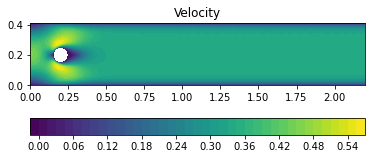

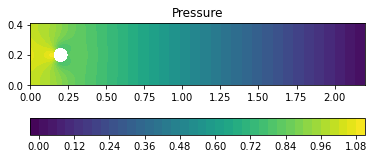

Done.

Solving on slab_25 = Ω x (0.78125, 0.8125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_26 = Ω x (0.8125, 0.84375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_27 = Ω x (0.84375, 0.875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_28 = Ω x (0.875, 0.90625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_29 = Ω x (0.90625, 0.9375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_30 = Ω x (0.9375, 0.96875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_31 = Ω x (0.96875, 1.0) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_32 = Ω x (1.0, 1.03125) ...
Spaces = [v,v,p,p,]
t = 1.03125:


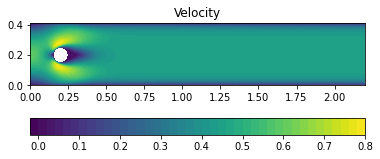

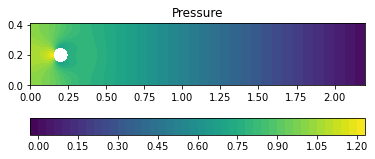

Done.

Solving on slab_33 = Ω x (1.03125, 1.0625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_34 = Ω x (1.0625, 1.09375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_35 = Ω x (1.09375, 1.125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_36 = Ω x (1.125, 1.15625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_37 = Ω x (1.15625, 1.1875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_38 = Ω x (1.1875, 1.21875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_39 = Ω x (1.21875, 1.25) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_40 = Ω x (1.25, 1.28125) ...
Spaces = [v,v,p,p,]
t = 1.28125:


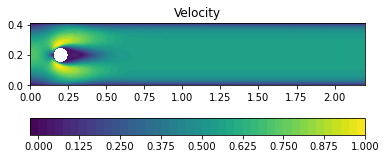

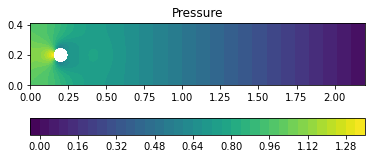

Done.

Solving on slab_41 = Ω x (1.28125, 1.3125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_42 = Ω x (1.3125, 1.34375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_43 = Ω x (1.34375, 1.375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_44 = Ω x (1.375, 1.40625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_45 = Ω x (1.40625, 1.4375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_46 = Ω x (1.4375, 1.46875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_47 = Ω x (1.46875, 1.5) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_48 = Ω x (1.5, 1.53125) ...
Spaces = [v,v,p,p,]
t = 1.53125:


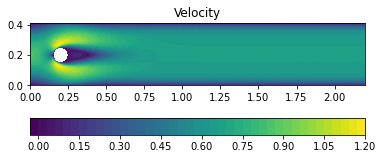

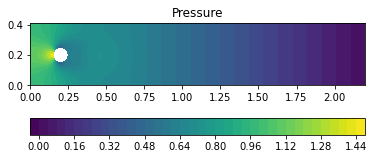

Done.

Solving on slab_49 = Ω x (1.53125, 1.5625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_50 = Ω x (1.5625, 1.59375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_51 = Ω x (1.59375, 1.625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_52 = Ω x (1.625, 1.65625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_53 = Ω x (1.65625, 1.6875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_54 = Ω x (1.6875, 1.71875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_55 = Ω x (1.71875, 1.75) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_56 = Ω x (1.75, 1.78125) ...
Spaces = [v,v,p,p,]
t = 1.78125:


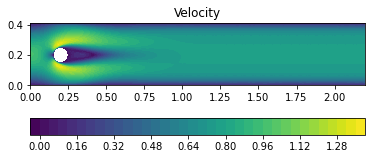

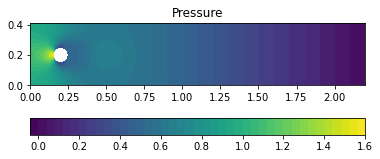

Done.

Solving on slab_57 = Ω x (1.78125, 1.8125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_58 = Ω x (1.8125, 1.84375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_59 = Ω x (1.84375, 1.875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_60 = Ω x (1.875, 1.90625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_61 = Ω x (1.90625, 1.9375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_62 = Ω x (1.9375, 1.96875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_63 = Ω x (1.96875, 2.0) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_64 = Ω x (2.0, 2.03125) ...
Spaces = [v,v,p,p,]
t = 2.03125:


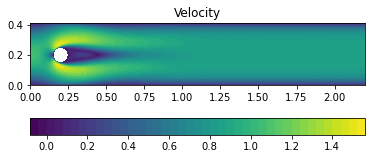

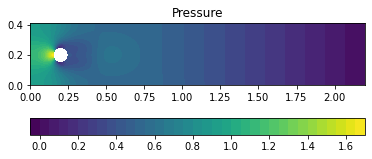

Done.

Solving on slab_65 = Ω x (2.03125, 2.0625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_66 = Ω x (2.0625, 2.09375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_67 = Ω x (2.09375, 2.125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_68 = Ω x (2.125, 2.15625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_69 = Ω x (2.15625, 2.1875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_70 = Ω x (2.1875, 2.21875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_71 = Ω x (2.21875, 2.25) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_72 = Ω x (2.25, 2.28125) ...
Spaces = [v,v,p,p,]
t = 2.28125:


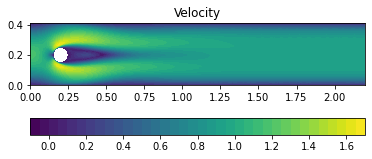

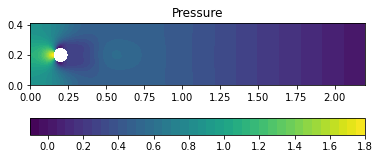

Done.

Solving on slab_73 = Ω x (2.28125, 2.3125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_74 = Ω x (2.3125, 2.34375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_75 = Ω x (2.34375, 2.375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_76 = Ω x (2.375, 2.40625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_77 = Ω x (2.40625, 2.4375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_78 = Ω x (2.4375, 2.46875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_79 = Ω x (2.46875, 2.5) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_80 = Ω x (2.5, 2.53125) ...
Spaces = [v,v,p,p,]
t = 2.53125:


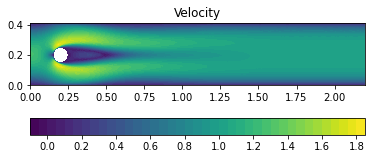

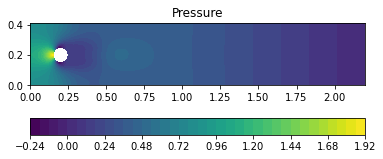

Done.

Solving on slab_81 = Ω x (2.53125, 2.5625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_82 = Ω x (2.5625, 2.59375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_83 = Ω x (2.59375, 2.625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_84 = Ω x (2.625, 2.65625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_85 = Ω x (2.65625, 2.6875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_86 = Ω x (2.6875, 2.71875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_87 = Ω x (2.71875, 2.75) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_88 = Ω x (2.75, 2.78125) ...
Spaces = [v,v,p,p,]
t = 2.78125:


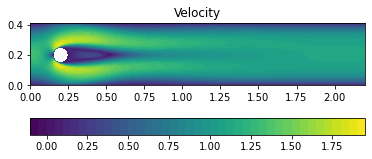

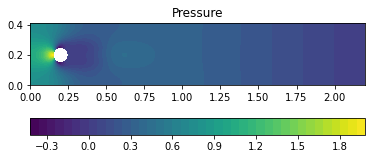

Done.

Solving on slab_89 = Ω x (2.78125, 2.8125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_90 = Ω x (2.8125, 2.84375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_91 = Ω x (2.84375, 2.875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_92 = Ω x (2.875, 2.90625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_93 = Ω x (2.90625, 2.9375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_94 = Ω x (2.9375, 2.96875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_95 = Ω x (2.96875, 3.0) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_96 = Ω x (3.0, 3.03125) ...
Spaces = [v,v,p,p,]
t = 3.03125:


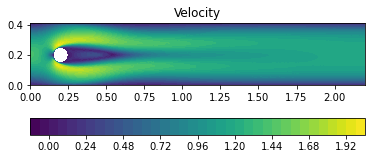

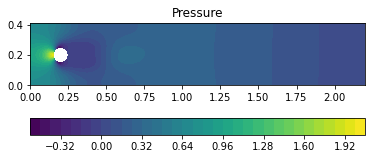

Done.

Solving on slab_97 = Ω x (3.03125, 3.0625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_98 = Ω x (3.0625, 3.09375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_99 = Ω x (3.09375, 3.125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_100 = Ω x (3.125, 3.15625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_101 = Ω x (3.15625, 3.1875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_102 = Ω x (3.1875, 3.21875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_103 = Ω x (3.21875, 3.25) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_104 = Ω x (3.25, 3.28125) ...
Spaces = [v,v,p,p,]
t = 3.28125:


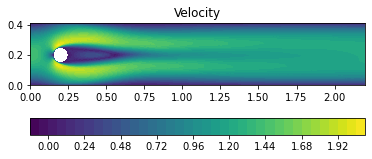

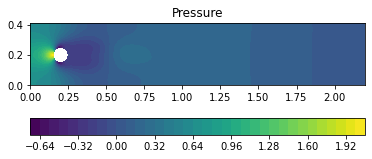

Done.

Solving on slab_105 = Ω x (3.28125, 3.3125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_106 = Ω x (3.3125, 3.34375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_107 = Ω x (3.34375, 3.375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_108 = Ω x (3.375, 3.40625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_109 = Ω x (3.40625, 3.4375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_110 = Ω x (3.4375, 3.46875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_111 = Ω x (3.46875, 3.5) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_112 = Ω x (3.5, 3.53125) ...
Spaces = [v,v,p,p,]
t = 3.53125:


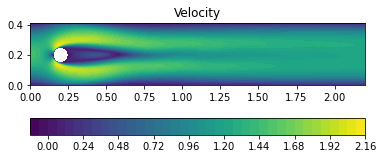

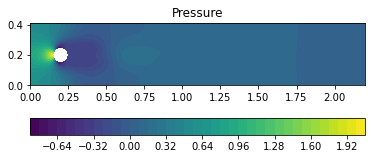

Done.

Solving on slab_113 = Ω x (3.53125, 3.5625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_114 = Ω x (3.5625, 3.59375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_115 = Ω x (3.59375, 3.625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_116 = Ω x (3.625, 3.65625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_117 = Ω x (3.65625, 3.6875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_118 = Ω x (3.6875, 3.71875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_119 = Ω x (3.71875, 3.75) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_120 = Ω x (3.75, 3.78125) ...
Spaces = [v,v,p,p,]
t = 3.78125:


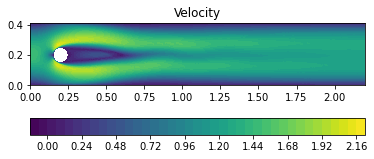

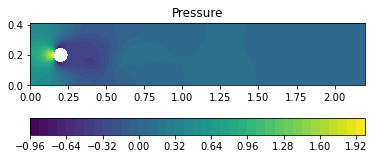

Done.

Solving on slab_121 = Ω x (3.78125, 3.8125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_122 = Ω x (3.8125, 3.84375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_123 = Ω x (3.84375, 3.875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_124 = Ω x (3.875, 3.90625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_125 = Ω x (3.90625, 3.9375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_126 = Ω x (3.9375, 3.96875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_127 = Ω x (3.96875, 4.0) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_128 = Ω x (4.0, 4.03125) ...
Spaces = [v,v,p,p,]
t = 4.03125:


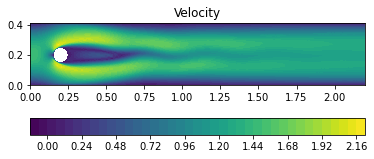

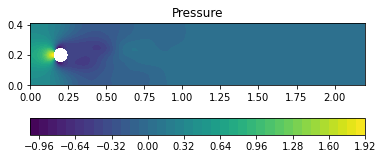

Done.

Solving on slab_129 = Ω x (4.03125, 4.0625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_130 = Ω x (4.0625, 4.09375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_131 = Ω x (4.09375, 4.125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_132 = Ω x (4.125, 4.15625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_133 = Ω x (4.15625, 4.1875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_134 = Ω x (4.1875, 4.21875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_135 = Ω x (4.21875, 4.25) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_136 = Ω x (4.25, 4.28125) ...
Spaces = [v,v,p,p,]
t = 4.28125:


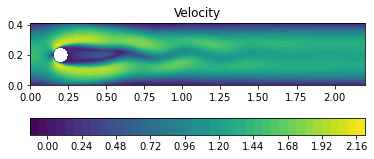

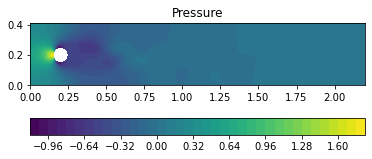

Done.

Solving on slab_137 = Ω x (4.28125, 4.3125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_138 = Ω x (4.3125, 4.34375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_139 = Ω x (4.34375, 4.375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_140 = Ω x (4.375, 4.40625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_141 = Ω x (4.40625, 4.4375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_142 = Ω x (4.4375, 4.46875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_143 = Ω x (4.46875, 4.5) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_144 = Ω x (4.5, 4.53125) ...
Spaces = [v,v,p,p,]
t = 4.53125:


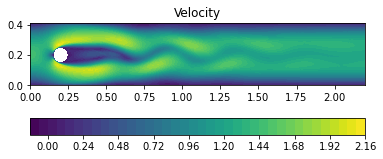

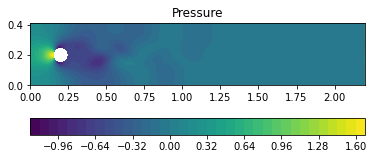

Done.

Solving on slab_145 = Ω x (4.53125, 4.5625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_146 = Ω x (4.5625, 4.59375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_147 = Ω x (4.59375, 4.625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_148 = Ω x (4.625, 4.65625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_149 = Ω x (4.65625, 4.6875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_150 = Ω x (4.6875, 4.71875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_151 = Ω x (4.71875, 4.75) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_152 = Ω x (4.75, 4.78125) ...
Spaces = [v,v,p,p,]
t = 4.78125:


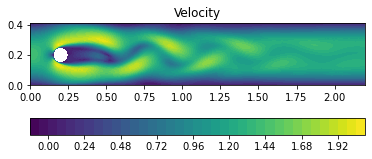

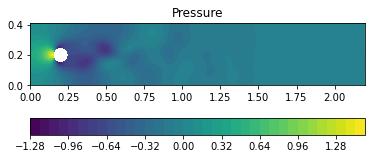

Done.

Solving on slab_153 = Ω x (4.78125, 4.8125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_154 = Ω x (4.8125, 4.84375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_155 = Ω x (4.84375, 4.875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_156 = Ω x (4.875, 4.90625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_157 = Ω x (4.90625, 4.9375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_158 = Ω x (4.9375, 4.96875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_159 = Ω x (4.96875, 5.0) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_160 = Ω x (5.0, 5.03125) ...
Spaces = [v,v,p,p,]
t = 5.03125:


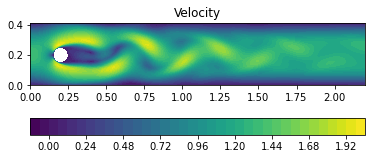

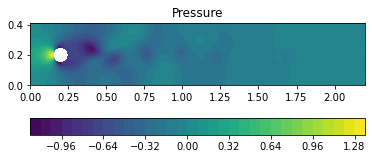

Done.

Solving on slab_161 = Ω x (5.03125, 5.0625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_162 = Ω x (5.0625, 5.09375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_163 = Ω x (5.09375, 5.125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_164 = Ω x (5.125, 5.15625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_165 = Ω x (5.15625, 5.1875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_166 = Ω x (5.1875, 5.21875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_167 = Ω x (5.21875, 5.25) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_168 = Ω x (5.25, 5.28125) ...
Spaces = [v,v,p,p,]
t = 5.28125:


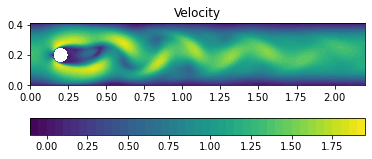

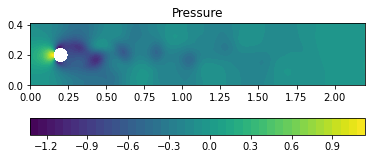

Done.

Solving on slab_169 = Ω x (5.28125, 5.3125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_170 = Ω x (5.3125, 5.34375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_171 = Ω x (5.34375, 5.375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_172 = Ω x (5.375, 5.40625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_173 = Ω x (5.40625, 5.4375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_174 = Ω x (5.4375, 5.46875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_175 = Ω x (5.46875, 5.5) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_176 = Ω x (5.5, 5.53125) ...
Spaces = [v,v,p,p,]
t = 5.53125:


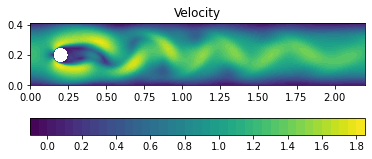

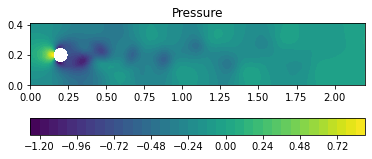

Done.

Solving on slab_177 = Ω x (5.53125, 5.5625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_178 = Ω x (5.5625, 5.59375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_179 = Ω x (5.59375, 5.625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_180 = Ω x (5.625, 5.65625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_181 = Ω x (5.65625, 5.6875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_182 = Ω x (5.6875, 5.71875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_183 = Ω x (5.71875, 5.75) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_184 = Ω x (5.75, 5.78125) ...
Spaces = [v,v,p,p,]
t = 5.78125:


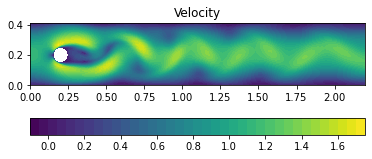

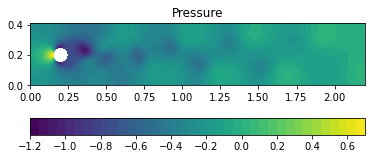

Done.

Solving on slab_185 = Ω x (5.78125, 5.8125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_186 = Ω x (5.8125, 5.84375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_187 = Ω x (5.84375, 5.875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_188 = Ω x (5.875, 5.90625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_189 = Ω x (5.90625, 5.9375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_190 = Ω x (5.9375, 5.96875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_191 = Ω x (5.96875, 6.0) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_192 = Ω x (6.0, 6.03125) ...
Spaces = [v,v,p,p,]
t = 6.03125:


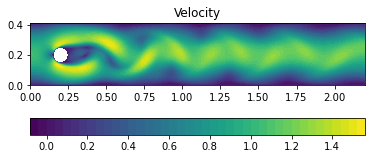

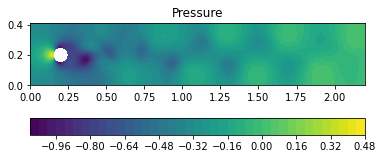

Done.

Solving on slab_193 = Ω x (6.03125, 6.0625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_194 = Ω x (6.0625, 6.09375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_195 = Ω x (6.09375, 6.125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_196 = Ω x (6.125, 6.15625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_197 = Ω x (6.15625, 6.1875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_198 = Ω x (6.1875, 6.21875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_199 = Ω x (6.21875, 6.25) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_200 = Ω x (6.25, 6.28125) ...
Spaces = [v,v,p,p,]
t = 6.28125:


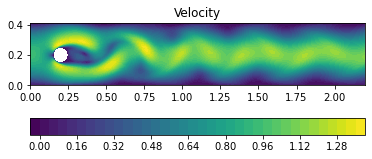

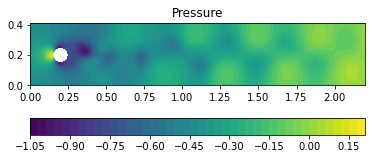

Done.

Solving on slab_201 = Ω x (6.28125, 6.3125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_202 = Ω x (6.3125, 6.34375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_203 = Ω x (6.34375, 6.375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_204 = Ω x (6.375, 6.40625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_205 = Ω x (6.40625, 6.4375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_206 = Ω x (6.4375, 6.46875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_207 = Ω x (6.46875, 6.5) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_208 = Ω x (6.5, 6.53125) ...
Spaces = [v,v,p,p,]
t = 6.53125:


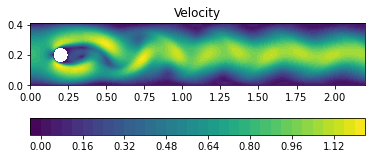

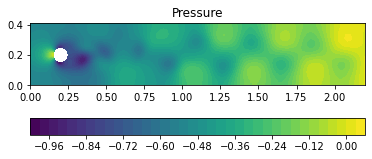

Done.

Solving on slab_209 = Ω x (6.53125, 6.5625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_210 = Ω x (6.5625, 6.59375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_211 = Ω x (6.59375, 6.625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_212 = Ω x (6.625, 6.65625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_213 = Ω x (6.65625, 6.6875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_214 = Ω x (6.6875, 6.71875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_215 = Ω x (6.71875, 6.75) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_216 = Ω x (6.75, 6.78125) ...
Spaces = [v,v,p,p,]
t = 6.78125:


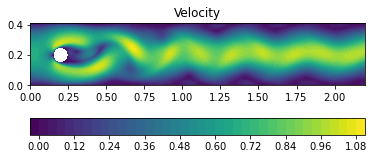

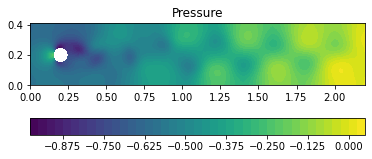

Done.

Solving on slab_217 = Ω x (6.78125, 6.8125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_218 = Ω x (6.8125, 6.84375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_219 = Ω x (6.84375, 6.875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_220 = Ω x (6.875, 6.90625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_221 = Ω x (6.90625, 6.9375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_222 = Ω x (6.9375, 6.96875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_223 = Ω x (6.96875, 7.0) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_224 = Ω x (7.0, 7.03125) ...
Spaces = [v,v,p,p,]
t = 7.03125:


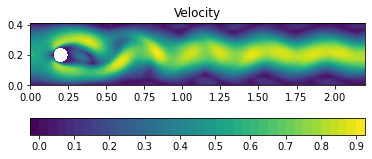

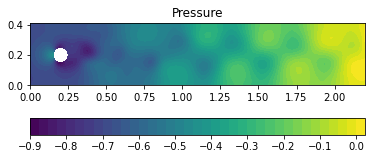

Done.

Solving on slab_225 = Ω x (7.03125, 7.0625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_226 = Ω x (7.0625, 7.09375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_227 = Ω x (7.09375, 7.125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_228 = Ω x (7.125, 7.15625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_229 = Ω x (7.15625, 7.1875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_230 = Ω x (7.1875, 7.21875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_231 = Ω x (7.21875, 7.25) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_232 = Ω x (7.25, 7.28125) ...
Spaces = [v,v,p,p,]
t = 7.28125:


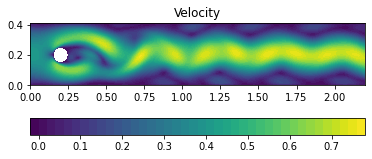

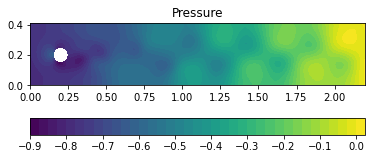

Done.

Solving on slab_233 = Ω x (7.28125, 7.3125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_234 = Ω x (7.3125, 7.34375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_235 = Ω x (7.34375, 7.375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_236 = Ω x (7.375, 7.40625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_237 = Ω x (7.40625, 7.4375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_238 = Ω x (7.4375, 7.46875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_239 = Ω x (7.46875, 7.5) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_240 = Ω x (7.5, 7.53125) ...
Spaces = [v,v,p,p,]
t = 7.53125:


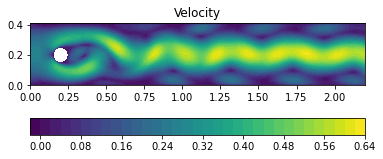

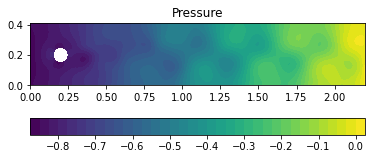

Done.

Solving on slab_241 = Ω x (7.53125, 7.5625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_242 = Ω x (7.5625, 7.59375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_243 = Ω x (7.59375, 7.625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_244 = Ω x (7.625, 7.65625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_245 = Ω x (7.65625, 7.6875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_246 = Ω x (7.6875, 7.71875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_247 = Ω x (7.71875, 7.75) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_248 = Ω x (7.75, 7.78125) ...
Spaces = [v,v,p,p,]
t = 7.78125:


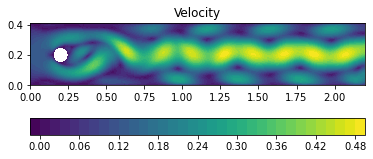

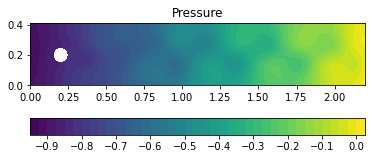

Done.

Solving on slab_249 = Ω x (7.78125, 7.8125) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_250 = Ω x (7.8125, 7.84375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_251 = Ω x (7.84375, 7.875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_252 = Ω x (7.875, 7.90625) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_253 = Ω x (7.90625, 7.9375) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_254 = Ω x (7.9375, 7.96875) ...
Spaces = [v,v,p,p,]
Done.

Solving on slab_255 = Ω x (7.96875, 8.0) ...
Spaces = [v,v,p,p,]
Done.

------------
| RESULTS: |
------------
Space-time Dofs: 14192640
CPU Time: 3635.69212 s 




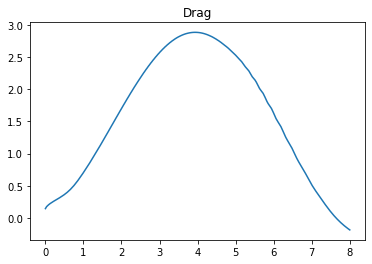

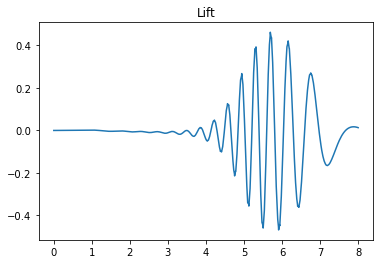

In [3]:
##############################################
# Start a time marching / time slabbing loop #
##############################################
start_time = 0.
end_time = 8.

s_v = 2
s_p = 1
r = 1
slab_size = 0.03125
n_x = 1
nu = 0.001

# start simulation
cpu_start_time = time.time()
print(f"CONFIG: problem = {PROBLEM}, s = ({s_v}/{s_p}), r = {r} ({TIME_DG_QUADRATURE}), slab_size = {slab_size}, n_x = {n_x}")

slabs = [(start_time, start_time+slab_size)]
while slabs[-1][1] < end_time - 1e-8:
    slabs.append((slabs[-1][1], slabs[-1][1]+slab_size))

# get spatial function space
#space_mesh = Mesh("schaefer_turek_2D_fine.xml") # decent results, fine mesh with ~50 K DoFs for Taylor-Hood
space_mesh = Mesh("schaefer_turek_2D_pygmsh.xml") # mesh with ~28 K DoFs for Taylor-Hood
# space_mesh = Mesh("schaefer_turek_2D.xml") # too coarse for accurate lift
plot(space_mesh, title="spatial mesh")
plt.show()
element = {
    "v": VectorElement("Lagrange", space_mesh.ufl_cell(), s_v),
    "p": FiniteElement("Lagrange", space_mesh.ufl_cell(), s_p),
}
Vh = FunctionSpace(space_mesh, MixedElement(*element.values())) # spatial function space for a single time point
print(f"Number of spatial DoFs: {Vh.dim()} ({Vh.sub(0).dim()} + {Vh.sub(1).dim()})")
Uh = Function(Vh)
Phih = TestFunctions(Vh)

# boundaries
inflow = CompiledSubDomain("near(x[0], 0) && on_boundary")
outflow = CompiledSubDomain("near(x[0], 2.2) && on_boundary")
walls = CompiledSubDomain("near(x[1], 0) || near(x[1], 0.41) && on_boundary")
cylinder = CompiledSubDomain("x[0]>0.1 && x[0]<0.3 && x[1]>0.1 && x[1]<0.3 && on_boundary")

facet_marker = MeshFunction("size_t", space_mesh, 1)
facet_marker.set_all(0)
inflow.mark(facet_marker, 1)
outflow.mark(facet_marker, 2)
walls.mark(facet_marker, 3)
cylinder.mark(facet_marker, 4)

ds_cylinder = Measure("ds", subdomain_data=facet_marker, subdomain_id=4)

# initial condition on slab
U0 = Function(Vh)
v0, p0 = split(U0)
U0 = interpolate(Constant((0.,0.,0.)), Vh)

# split functions into velocity and pressure components
v, p = split(Uh)
phi_v, phi_p = Phih

# preassemble spatial forms
#mass_form = dot(v, phi_v) * dx
#laplace_form = inner(grad(v), grad(phi_v)) * dx
#pressure_form = p * div(phi_v) * dx
#div_form = div(v) * phi_p * dx
#convection_form = dot(dot(grad(v), v), phi_v) * dx

# pre-assemble drag and lift
dU = TrialFunction(Vh) 
dv, dp = split(dU)
D = 0.1
v_bar = 2/3 * 4.0*1.5*0.205*(0.41 - 0.205) / pow(0.41, 2)
n = FacetNormal(space_mesh)
drag_vector = assemble(
    2/(v_bar**2*D)*
    (
    - dot(dp * Identity(len(dv)) , -n)[0]
    + nu * dot(grad(dv), -n)[0]
    ) * ds_cylinder
).get_local()

lift_vector = assemble(
    2/(v_bar**2*D)*
    (
    - dot(dp * Identity(len(dv)) , -n)[1]
    + nu * dot(grad(dv), -n)[1]
    ) * ds_cylinder
).get_local()

drag_values = []
lift_values = []
times_draglift = []
total_n_dofs = 0
total_time_n_dofs = 0

#####################
# Time slabbing loop:
for k, slab in enumerate(slabs):
    print(f"Solving on slab_{k} = Ω x ({round(slab[0],5)}, {round(slab[1],5)}) ...")

    #########################################
    # Create temporal finite element object #
    #########################################
    Time = TimeFE(r=r, a=slab[0], b=slab[1], n_time=1, n_q_points=r+1)
    
    V = FunctionSpace(space_mesh, MixedElement(*[element["v"] for _ in range(Time.n_dofs)], *[element["p"] for _ in range(Time.n_dofs)]))
    n_subspaces = V.num_sub_spaces()
    print("Spaces = [", end="")
    for i in range(n_subspaces):
        if V.sub(i).num_sub_spaces() == 2:
            print("v", end=",")
        else:
            print("p", end=",")
    print("]")
    
    U_kh = Function(V)
    Phi_kh = TestFunctions(V)

    # split U_kh and Phi_kh into velocity and pressure parts
    U = {"v": split(U_kh)[:Time.n_dofs], "p": split(U_kh)[Time.n_dofs:]}
    Phi = {"v": Phi_kh[:Time.n_dofs], "p": Phi_kh[Time.n_dofs:]}
    
    # start with "empty" space-time variational form
    F = Constant(0.)*U["p"][0]*Phi["p"][0]*dx
    
    # ================= #
    #   (v,v) - Block   #
    # ================= #
    
    # volume integrals
    for time_element in Time.mesh:
        # assemble linear terms
        for i in Time.local_dofs[time_element]:
            for j in Time.local_dofs[time_element]:
                for (t_q, w_q) in Time.quadrature[time_element]:
                    # TODO: to reduce the number of terms in the sum, the sum over the temporal quadrature can be evaluated prior to adding to the form F
                    F += Constant(w_q * Time.dt_phi[j](t_q) * Time.phi[i](t_q)) \
                        * dot(U["v"][j], Phi["v"][i]) * dx
                    F += Constant(w_q * Time.phi[j](t_q) * Time.phi[i](t_q)) \
                        * Constant(nu) * inner(grad(U["v"][j]), grad(Phi["v"][i])) * dx
        # assemble nonlinearity
        for i in Time.local_dofs[time_element]:
            for j in Time.local_dofs[time_element]:
                for l in Time.local_dofs[time_element]:
                    # NOTE: For nonlinearities make sure that the temporal quadrature is fine enough
                    # E.g. for the nonlinearity u^2, we need to be able to integrate polynomials of degree 3r exactly in time
                    #      for this we need Gauss-Legendre quadrature of degree >= (3r+1)/2
                    for (t_q, w_q) in Time.quadrature_fine[time_element]:
                        F += Constant(w_q * Time.phi[j](t_q) * Time.phi[l](t_q) * Time.phi[i](t_q)) \
                            * dot(dot(grad(U["v"][j]), U["v"][l]), Phi["v"][i])* dx   
                        
    # RHS integral
    for n, time_element in enumerate(Time.mesh):
        for i in Time.local_dofs[time_element]:
            # initial condition
            if n == 0:
                F -=  Constant(Time.phi[i](time_element[0]+Time.epsilon)) * inner(v0, Phi["v"][i]) * dx

    # jump terms (NOTE: For Gauss-Lobatto dG basis, we could hard code the values for the jump term)
    for n, time_element in enumerate(Time.mesh):
        # a) v_m^+ * φ_m^{v,+}
        for i in Time.local_dofs[time_element]:
            for j in Time.local_dofs[time_element]:
                F += Constant(Time.phi[j](time_element[0]+Time.epsilon) * Time.phi[i](time_element[0]+Time.epsilon)) * inner(U["v"][j], Phi["v"][i]) * dx

        # b) v_{m-1}^- * φ_m^{v,+}
        if n > 0:
            prev_time_element = Time.mesh[n-1]
            for i in Time.local_dofs[time_element]:
                for j in Time.local_dofs[prev_time_element]:
                    F += Constant((-1.) * Time.phi[j](prev_time_element[1]-Time.epsilon) * Time.phi[i](time_element[0]+Time.epsilon)) * inner(U["v"][j], Phi["v"][i]) * dx       

    # ================= #
    #   (v,p) - Block   #
    # ================= #
    
    # volume integral
    for time_element in Time.mesh:
        for i in Time.local_dofs[time_element]:
            for j in Time.local_dofs[time_element]:
                for (t_q, w_q) in Time.quadrature[time_element]:
                    F += Constant(w_q * Time.phi[j](t_q) * Time.phi[i](t_q)) \
                        * Constant(-1.) * U["p"][j] * div(Phi["v"][i]) * dx
    
    # ================= #
    #   (p,v) - Block   #
    # ================= #
        
    # volume integral
    for time_element in Time.mesh:
        for i in Time.local_dofs[time_element]:
            for j in Time.local_dofs[time_element]:
                for (t_q, w_q) in Time.quadrature[time_element]:
                    F += Constant(w_q * Time.phi[j](t_q) * Time.phi[i](t_q)) \
                        * Constant(-1.) * div(U["v"][j]) * Phi["p"][i] * dx

    # define time dependent Dirichlet boundary conditions
    bcs = []
    for i, t_q in enumerate(Time.dof_locations):
        inflow_parabola = ("0","0")
        if PROBLEM == "2D-2":
            inflow_parabola = ("4.0*1.5*x[1]*(0.41 - x[1]) / pow(0.41, 2)", "0")
        elif PROBLEM == "2D-3":
            inflow_parabola = ("4.0*1.5*sin(0.125*pi*t)*x[1]*(0.41 - x[1]) / pow(0.41, 2)", "0")
        else:
            raise NotImplementedError(f"Problem {PROBLEM} has not been implemented yet.")
        
        bcs.append(DirichletBC(V.sub(i), Expression(inflow_parabola, degree=2, pi=np.pi, t=t_q), inflow))
        bcs.append(DirichletBC(V.sub(i), Constant((0, 0)), walls))
        bcs.append(DirichletBC(V.sub(i), Constant((0, 0)), cylinder))

    # solve problem
    solve(F == 0, U_kh, bcs)

    solutions_v = [U_kh.sub(i, deepcopy=True).vector() for i in range(Time.n_dofs)]
    offset_v = Time.n_dofs
    solutions_p = [U_kh.sub(i + offset_v, deepcopy=True).vector() for i in range(Time.n_dofs)]
    
    # get v0 for next slab
    U0.vector().set_local(np.concatenate((
        Time.get_solution_at_time(slab[1]-Time.epsilon, solutions_v),
        Time.get_solution_at_time(slab[1]-Time.epsilon, solutions_p) #np.zeros((Vh.sub(1).dim(),))
    )))
    v0, p0 = split(U0)
    
    if k % 8 == 0:
        # plot final solution on slab
        print(f"t = {slab[1]}:")
        c = plot(sqrt(dot(v0, v0)), title="Velocity")
        plt.colorbar(c, orientation="horizontal")
        plt.show()
        c = plot(p0, title="Pressure")
        plt.colorbar(c, orientation="horizontal")
        plt.show()

    # compute functional values
    total_time_n_dofs += Time.n_dofs
    total_n_dofs += Vh.dim() * Time.n_dofs 
    for time_element in Time.mesh:
        for (t_q, _) in Time.quadrature_fine[time_element]:
            Uq = np.concatenate((
                Time.get_solution_at_time(t_q, solutions_v),
                Time.get_solution_at_time(t_q, solutions_p)
            ))
            drag_values.append(drag_vector.dot(Uq))
            lift_values.append(lift_vector.dot(Uq))
            times_draglift.append(t_q)
            
    print("Done.\n")
    
print("------------")
print("| RESULTS: |")
print("------------")
print(f"Space-time Dofs: {total_n_dofs}")
cpu_time = round(time.time() - cpu_start_time, 5)
print(f"CPU Time: {cpu_time} s \n\n")

plt.title("Drag")
plt.plot(times_draglift, drag_values)
plt.show()

plt.title("Lift")
plt.plot(times_draglift, lift_values)
plt.show()